# Logistic Regression, Bayes and EM


## In this exercise I will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize results.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

In [4]:
f_1000_0 = training_set.values[:1000][ training_set.values[:1000][:,-1]==0 ]
f_1000_1 = training_set.values[:1000][ training_set.values[:1000][:,-1]==1 ]
all_0 = training_set.values[ training_set.values[:,-1]==0 ]
all_1 = training_set.values[ training_set.values[:,-1]==1 ]

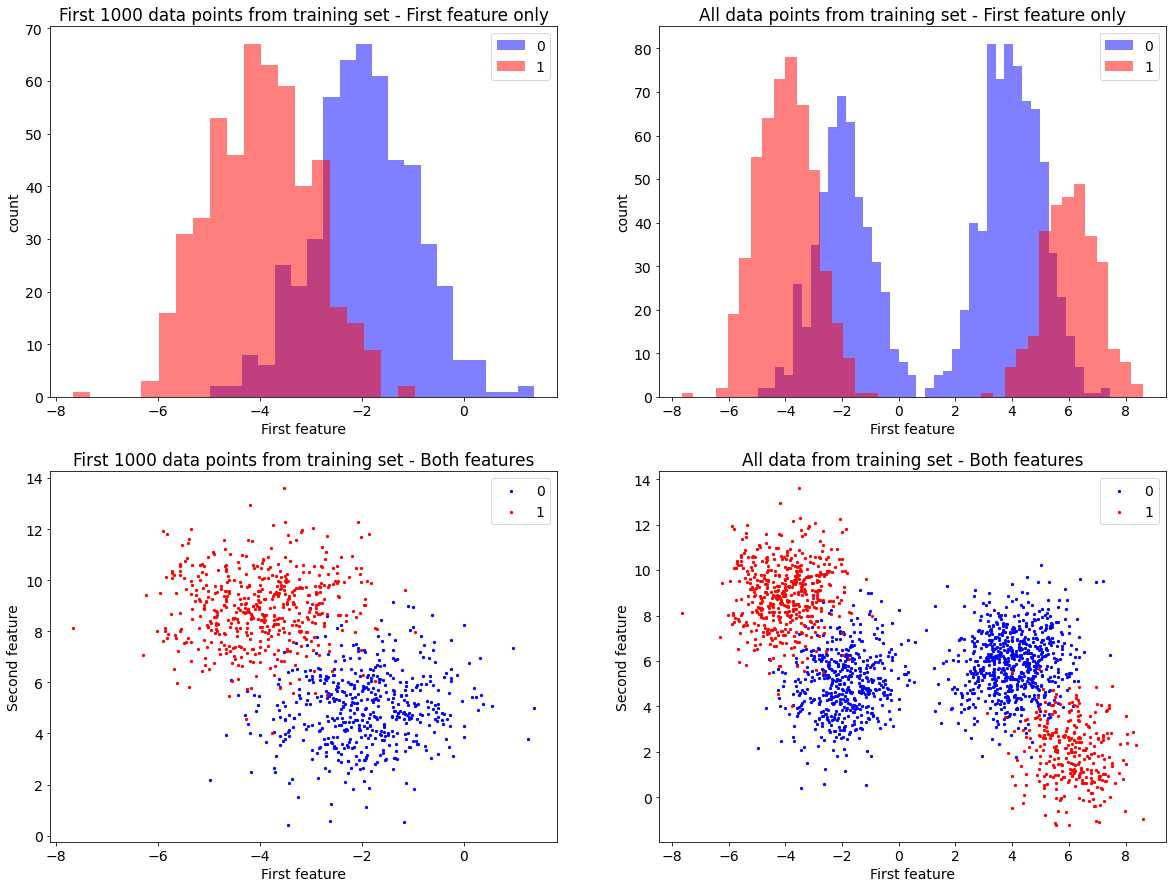

In [5]:
plt.subplots(figsize=(20, 15))
plt.rc('font', size=14) 

plt.subplot(2,2,1)
plt.hist(f_1000_0[:,0], bins = 20, alpha=0.5, label="0", color="blue")
plt.hist(f_1000_1[:,0], bins = 20, alpha=0.5, label="1", color="red")
plt.title('First 1000 data points from training set - First feature only')
plt.xlabel('First feature')
plt.ylabel('count')
plt.legend()

plt.subplot(2,2,2)
plt.hist(all_0[:,0], bins = 40, alpha=0.5, label="0", color="blue")
plt.hist(all_1[:,0], bins = 40, alpha=0.5, label="1", color="red")
plt.title('All data points from training set - First feature only')
plt.xlabel('First feature')
plt.ylabel('count')
plt.legend()

plt.subplot(2,2,3)
plt.scatter(f_1000_0[:,0], f_1000_0[:,1] ,s = 5,c = 'blue' , label = "0")
plt.scatter(f_1000_1[:,0], f_1000_1[:,1] ,s = 5,c = 'red' , label = "1")
plt.title('First 1000 data points from training set - Both features')
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.legend()

plt.subplot(2,2,4)
plt.scatter(all_0[:,0],all_0[:,1] ,s = 5,c = 'blue' , label = "0")
plt.scatter(all_1[:,0],all_1[:,1] ,s = 5,c = 'red' , label = "1")
plt.title('All data from training set - Both features')
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.legend()

plt.show()

## Logistic Regression


Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [6]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = None
        self.cost_history = []
       
    def sigmoid(self,w,x):
        sigmoid = 1 / (1 + np.exp(x @ ((-1)*(w.T))))
        return sigmoid

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
       
        bias_x = np.append(np.ones((X.shape[0],1)), X, axis = 1)                          # adding ones culoumn to X
        self.cost_history = [np.Inf]
        np.random.seed(self.random_state)
        self.theta = np.random.rand(bias_x.shape[1])
        for i in range(self.n_iter):
            h_x =  1 / (1 + np.exp(- bias_x @ self.theta))                                # calculating hypotesis h(x):
            cur_cost = np.sum((- y @ np.log(h_x)) - ((1 - y) @ np.log(1 - h_x))) / len(y) # calculating the current cost  
            self.cost_history.append(cur_cost)
            
            #if the change in cost is larger than eps, then update weights (after iteration no.2):
            if np.abs(self.cost_history[-1] - self.cost_history[-2]) > self.eps:  
                for j in range(len(self.theta)):
                    sigma = (h_x - y) @ bias_x[:,j]
                    delta = - self.eta * sigma
                    self.theta[j] += delta
            else:
                break
        return
    
    def predict(self, X):
        """Return the predicted class label"""
        bias_X = np.append(np.ones((X.shape[0],1)), X, axis=1)
        prediction = []
        for i in range (X.shape[0]):
            prediction.append([1 / (1 + np.exp(-bias_X[i,:] @ self.theta))])
        prediction = np.where(np.array(prediction)>0.5,1,0)
        return prediction
    
    def accuracy(self, X, y):
        num_inst = len(X)
        correct = 0
        prediction = self.predict(X)
        for i in range(num_inst):
              if prediction[i] == y[i]:
                correct += 1
        return correct / num_inst

## Cross Validation


Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [7]:
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

def cross_validation(X, y):
    y = y.reshape(2000, 1)
    new_data = np.hstack((X,y))
    np.random.shuffle(new_data)   #shuffling the data
   
    shuffled_X = new_data[:,0:-1]
    shuffled_y = new_data[:,-1]

    #init 5 empty subsets for every kind of set:
    subsets_X_val = [None]*5
    subsets_y_val = [None]*5
    subsets_X_training = [None]*5
    subsets_y_training = [None]*5
    for i in np.arange(5): 
        subsets_X_val[i] = shuffled_X[(400*i):(400*(i+1))]
        subsets_y_val[i] = shuffled_y[(400*i):(400*(i+1))]
        subsets_X_training[i] = np.delete(shuffled_X, np.s_[(400*i):(400*(i+1))],axis = 0)
        subsets_y_training[i] = np.delete(shuffled_y, np.s_[(400*i):(400*(i+1))])

    max_acc = 0        # max accuracy to be achived
    best_eta = None    # best eta to be achived
    best_eps = None    # best eps to be achived
    for eta in etas:
        for eps in epss:
            cur_acc = 0
            for i in np.arange(5):
                lor = LogisticRegressionGD(eta = eta, eps = eps)
                lor.fit(subsets_X_training[i],subsets_y_training[i])
                cur_acc += lor.accuracy(subsets_X_val[i],subsets_y_val[i])
            mean_acc = cur_acc / 5  # calculating the mean accuracy for the cross validation
            if mean_acc > max_acc:
                max_acc = mean_acc
                best_eta = eta
                best_eps = eps
                
    return best_eta, best_eps, max_acc

In [8]:
# finding best parameters with cross validation
best_eta , best_eps, max_acc = cross_validation(X_training, y_training)
print(f'the best parameters are:\n\t eta = {best_eta}\n\t esp = {best_eps}\n\t accuracy = {max_acc}')

the best parameters are:
	 eta = 5e-05
	 esp = 1e-06
	 accuracy = 0.8005000000000001


## Normal distribution pdf


Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [9]:
# calc normal pdf    
def norm_pdf(data, mu, sigma):  
    return np.exp(-0.5 * (((data-mu)/ sigma) ** 2)) / (sigma * np.sqrt(2 * np.pi))

## Expectation Maximization


Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [10]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01,random_state = 1):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.resp_arr = None # an array of responsabilites per feature per gaussian 
        self.mu_arr = None # an array of mu parameters (len = num of gaussians)
        self.sigma_arr = None # an array of sigma parameters (len = num of gaussians)
        self.w_arr = None  # an array of wieghts parameters (len = num of gaussians)
        self.costs_J = np.array([np.Inf, 0])
        
    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        
        np.random.seed(self.random_state)
        self.resp_arr = np.ones((data.shape[0],self.k))
        self.mu_arr = np.random.randint(low = 5, high = 10, size = self.k) * 0.1
        self.sigma_arr = np.random.randint(low = 5, high = 10, size = self.k) * 0.1
        self.w_arr = np.ones(self.k) * (1/self.k)  
        return
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        resp_sum = np.zeros(data.shape)
        for j in range(self.k):
            weighted_pdf = self.w_arr[j] * norm_pdf(data, self.mu_arr[j], self.sigma_arr[j])
            resp_sum += weighted_pdf
    
        for j in range(self.k):
            weighted_pdf = self.w_arr[j] * norm_pdf(data, self.mu_arr[j], self.sigma_arr[j])
            self.resp_arr[:,j] = weighted_pdf / resp_sum
        return

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        num_inst = len(data)
        for i in range(self.k):
            self.w_arr[i] = np.sum(self.resp_arr[:,i]) / num_inst
            self.mu_arr[i] = np.sum((self.resp_arr[:,i]) * data) / (self.w_arr[i] * num_inst)
            self.sigma_arr[i] = np.sqrt((np.sum((self.resp_arr[:,i]) * ((data - self.mu_arr[i])**2)) / (self.w_arr[i] * num_inst)))
        return
        
    def fit(self, data):
        
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        cur_cost = 0
        prev_cost = np.inf
        counter = 0 
        while ((counter < self.n_iter) and (np.abs(self.costs_J[-2] - self.costs_J[-1])) > self.eps) or counter < 2 :
            self.expectation(data)
            self.maximization(data)
            if counter >= 1:
                self.costs_J = np.append(self.costs_J, cur_cost)
            
            cost_temp = 0
            for i in range(self.k):
                cost_temp += (self.w_arr[i] * norm_pdf(data ,self.mu_arr[i], self.sigma_arr[i])) # the sum of all the GMM pdf
            cur_cost = np.sum(-np.log(cost_temp))
            counter += 1                
        return                
    
    def get_dist_params(self):
        return self.mu_arr, self.sigma_arr , self.w_arr

## Naive Bayes

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [11]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.priors = {}
        self.param_dict = {}
        self.class_values = None
        
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        full_data = np.append(X,y.reshape(y.shape[0], 1), axis = 1) # merging the data with their targets
        
        #calculating priors:
        self.class_values = np.unique(y)
        for clas in self.class_values:
            self.priors[clas] = len(y[y == clas]) / len(y)
        
        # gaussian parameters per feature per class:
        for clas in self.class_values:
            self.param_dict[clas] = {}
            data_per_class = full_data[full_data[:,-1] == clas][:,0:-1]
            for feature in range(X.shape[1]):
                em = EM(k = self.k)
                em.init_params(data_per_class[:,feature])
                em.fit(data_per_class[:,feature])
                self.param_dict[clas][feature] = (em.get_dist_params())  # updating mu, sigma, w    
        return
    
    def GMM_pdf(self, X, clas):
        total_pdf = np.ones(X.shape[0]) 
        for feature in range(X.shape[1]):
            feature_pdf = np.zeros(X.shape[0]) 
            for i in range(self.k):
                mu = self.param_dict[clas][feature][0][i]
                sigma = self.param_dict[clas][feature][1][i]
                w = self.param_dict[clas][feature][2][i]
                feature_pdf += w * norm_pdf(X[:,feature], mu, sigma)
            total_pdf *= feature_pdf
        return total_pdf
            
    def get_posterior(self, X, class_value):
        posterior = self.GMM_pdf(X, class_value) * self.priors[class_value]
        return posterior
    
    def predict(self, X):
        """Return the predicted class label"""
        prediction = np.zeros(X.shape[0])
        num_classes = len(self.class_values)
        #print(f'class values ={self.class_values}')
        posterior_1 = self.get_posterior(X, 1)
        posterior_0 = self.get_posterior(X, 0)
        for i in range(X.shape[0]):
            if posterior_1[i] > posterior_0[i]:
                prediction[i] = 1
        return prediction
    
    def accuracy(self, X, y):
        num_inst = len(X)
        correct = 0
        prediction = self.predict(X)
        for i in range(num_inst):
            if prediction[i] == y[i]:
                correct += 1
        return correct / num_inst

## Model evaluation


In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

def EM_accuracy(NBG, X, y):
    num_inst = X.shape[0]
    correct = 0
    for i in range(num_inst):
        if NBG.predict(X[i]) == y[i]:
            correct += 1
    #print(correct, num_inst)
    return correct / num_inst
    

In [ ]:
# Dividing the data:
X_tr = X_training[:1000]
y_tr = y_training[:1000]
X_ts = X_test[:500]
y_ts = y_test[:500]

# training Logistic Regression model:
LOR_1000 = LogisticRegressionGD()
LOR_1000.fit(X_tr, y_tr)

LOR_acc_1000 = LOR_1000.accuracy(X_tr, y_tr)    
LOR_acc_500 = LOR_1000.accuracy(X_ts, y_ts)    

# training Naive Bayes model model:
NBG_1000 = NaiveBayesGaussian(k=1) 
NBG_1000.fit(X_tr, y_tr)

# calculating accuracies:
NBG_acc_1000 = NBG_1000.accuracy(X_tr ,y_tr)
NBG_acc_500 = NBG_1000.accuracy(X_ts ,y_ts)

print("Logistic Regression model:\n")
print("\t train accuracy - first 1000 instances = {}".format(LOR_acc_1000))
print("\t test accuracy - first 500 instances = {}".format(LOR_acc_500))
print(" ")
print("Naive Bayes model: \n")
print("\t train accuracy - first 1000 instances = {}".format(NBG_acc_1000))
print("\t test accuracy - first 500 instances = {}".format(NBG_acc_500))

# plot decisions boundaries:
plot_decision_regions(X_tr,y_tr, LOR_1000)
plt.title("Decision boundaries of Logistic regression - 1000 points", fontsize = 16)
plt.xlabel("x1",fontsize= 14)
plt.ylabel("x2",fontsize= 14)
plt.show()

plot_decision_regions(X_tr ,y_tr, NBG_1000)
plt.title("Decision boundaries of Naive Bayes - 1000 points", fontsize = 16)
plt.xlabel("x1",fontsize= 14)
plt.ylabel("x2",fontsize= 14)
plt.show()

print("We observe that a linear seperator was found and it fits reasonably with the data observed.")

print("We observe a separator that isn't linear, as expected.")

print("We can observe a harmonically decreasing value in the COST as each iteration improves the hpyothesis.")

# ploting costs VS iterations:
plt.plot(LOR_1000.cost_history)
plt.title("Cost Vs iterations, logistic regression - 1000 points", fontsize = 16)
plt.xlabel("Iterations", fontsize = 14)
plt.ylabel("cost", fontsize = 14)
plt.show()

Logistic Regression model:

	 train accuracy - first 1000 instances = 0.965
	 test accuracy - first 500 instances = 0.938
 
Naive Bayes model: 

	 train accuracy - first 1000 instances = 0.966
	 test accuracy - first 500 instances = 0.942


In [ ]:
# models for the full dataset:
LOR_2000 = LogisticRegressionGD()
LOR_2000.fit(X_training, y_training)

LOR_acc_train = LOR_2000.accuracy(X_training, y_training)    
LOR_acc_test = LOR_2000.accuracy(X_test, y_test)    

# training Naive Bayes model model:
NBG_2000 = NaiveBayesGaussian(k=2) 
NBG_2000.fit(X_training, y_training)

# calculating accuracies:
NBG_acc_train = NBG_2000.accuracy(X_training, y_training)
NBG_acc_test = NBG_2000.accuracy(X_test ,y_test)

print("Accuracies - full dataset:\n")
print("Logistic Regression model:\n")
print("\t train accuracy - full data = {}".format(LOR_acc_train))
print("\t test accuracy - full data = {}".format(LOR_acc_test))
print(" ")
print("Naive Bayes model: \n")
print("\t train accuracy - full data = {}".format(NBG_acc_train))
print("\t test accuracy - full data = {}".format(NBG_acc_test))

# plot decisions boundaries:
plot_decision_regions(X_training, y_training, LOR_2000)
plt.title("Decision boundaries of Logistic regression - full dataset", fontsize = 16)
plt.xlabel("x1",fontsize= 14)
plt.ylabel("x2",fontsize= 14)
plt.show()

plot_decision_regions(X_training, y_training, NBG_2000)
plt.title("Decision boundaries of Naive Bayes -  full dataset", fontsize = 16)
plt.xlabel("x1",fontsize= 14)
plt.ylabel("x2",fontsize= 14)
plt.show()

# ploting costs VS iterations:
plt.plot(LOR_2000.cost_history)
plt.title("Cost Vs iterations, logistic regression -  full dataset", fontsize = 16)
plt.xscale("log")
plt.xlabel("Iterations", fontsize = 14)
plt.ylabel("cost", fontsize = 14)
plt.show()

## Open question

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

### Explenation:

The more data is closer to being liniary sepreable the more accurate results from the Logistic Regression method will yeild.
This is under the assumption that the data is not casted to higher dimentions. 
Recall that in our implementation of Naive bayes under the EM algorithm we used the assumption that the data is distributed by the normal distribution. If it were handed data that is distributed differently we would expect to see worse results.

We created one data set consisting of instances that are generated from 3 different 3-variant-gaussians.

To give Naive bayes the upper hand we labled the data such that the likelihood of an instance to be from a gaussian is in correlation to a lable. On the other hand the gaussians representing the labels are not liniary seperable.

To give the Logistic Regression the upper hand we split the labels around the centered gaussian, thus under each class of the data is'nt distributed normaly but is more likely to be liniary seperable

#### Code and explanations here ####


In [ ]:
np.random.seed(1)
mean1 = [5, 5, 5]
mean2 = [10, 10, 10]
mean3 = [15, 15, 15]
cov = [[1, 0, 0],[0, 1, 0],[0, 0, 1]]
g1 = np.random.multivariate_normal(mean1, cov, 500)
g2 = np.random.multivariate_normal(mean2, cov, 500)
g3 = np.random.multivariate_normal(mean3, cov, 500)
labels = np.hstack((np.zeros(500),np.ones(500),np.zeros(500))).reshape(1500,1)
data = np.vstack((g1,g2,g3))
data_n = np.hstack((data, labels))

In [ ]:
np.random.seed(1)
np.random.shuffle(data_n) #shuffling the data
shuffled_train = data_n[:1200,:]
shuffled_test = data_n[1200:,:]

In [ ]:
LOR_new = LogisticRegressionGD()
LOR_new.fit(shuffled_train[:,:-1], shuffled_train[:,-1])

LOR_acc_train = LOR_new.accuracy(shuffled_train[:,:-1], shuffled_train[:,-1])    
LOR_acc_test = LOR_new.accuracy(shuffled_test[:,:-1], shuffled_test[:,-1])    

# training Naive Bayes model model:
NBG_new = NaiveBayesGaussian(k=2) 
NBG_new.fit(shuffled_train[:,:-1],shuffled_train[:,-1])
# calculating accuracies:
NBG_acc_train = NBG_new.accuracy(shuffled_train[:,:-1], shuffled_train[:,-1])
NBG_acc_test = NBG_new.accuracy(shuffled_test[:,:-1] ,shuffled_test[:,-1])

print("Accuracies - new dataset:\n")
print("Logistic Regression model:\n")
print("\t train accuracy - full data = {}".format(LOR_acc_train))
print("\t test accuracy - full data = {}".format(LOR_acc_test))
print(" ")
print("Naive Bayes model: \n")
print("\t train accuracy - full data = {}".format(NBG_acc_train))
print("\t test accuracy - full data = {}".format(NBG_acc_test))

In [ ]:
data_0 = data_n[data_n[:,-1]==0]
data_1 = data_n[data_n[:,-1]==1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = data_0[:,0], ys = data_0[:,1], zs = data_0[:,2], label="0", color="red")
ax.scatter(xs = data_1[:,0], ys = data_1[:,1], zs = data_1[:,2], label="1", color="blue")

ax.set_title("Data which works better with Naive Bayes")
ax.set_xlabel("feature1")
ax.set_ylabel("feature2")
ax.set_zlabel("feature3")
ax.legend(loc="best")

plt.show()

In [ ]:
labels_2 = np.hstack((np.zeros(750),np.ones(750))).reshape(1500,1)
data_l = np.hstack((data, labels_2))

In [ ]:
np.random.seed(1)
np.random.shuffle(data_l) #shuffling the data
shuffled_train = data_l[:1200,:]
shuffled_test = data_l[1200:,:]

In [ ]:
LOR_new = LogisticRegressionGD()
LOR_new.fit(shuffled_train[:,:-1], shuffled_train[:,-1])

LOR_acc_train = LOR_new.accuracy(shuffled_train[:,:-1], shuffled_train[:,-1])    
LOR_acc_test = LOR_new.accuracy(shuffled_test[:,:-1], shuffled_test[:,-1])    

# training Naive Bayes model model:
NBG_new = NaiveBayesGaussian(k=2) 
NBG_new.fit(shuffled_train[:,:-1],shuffled_train[:,-1])
# calculating accuracies:
NBG_acc_train = NBG_new.accuracy(shuffled_train[:,:-1], shuffled_train[:,-1])
NBG_acc_test = NBG_new.accuracy(shuffled_test[:,:-1] ,shuffled_test[:,-1])

print("Accuracies - new dataset:\n")
print("Logistic Regression model:\n")
print("\t train accuracy - full data = {}".format(LOR_acc_train))
print("\t test accuracy - full data = {}".format(LOR_acc_test))
print(" ")
print("Naive Bayes model: \n")
print("\t train accuracy - full data = {}".format(NBG_acc_train))
print("\t test accuracy - full data = {}".format(NBG_acc_test))

In [ ]:
data_0 = data_l[data_l[:,-1]==0]
data_1 = data_l[data_l[:,-1]==1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = data_0[:,0], ys = data_0[:,1], zs = data_0[:,2], label="0", color="red")
ax.scatter(xs = data_1[:,0], ys = data_1[:,1], zs = data_1[:,2], label="1", color="blue")

ax.set_title("Data which works better with Logistic regression")
ax.set_xlabel("feature1")
ax.set_ylabel("feature2")
ax.set_zlabel("feature3")
ax.legend(loc="best")

    
plt.show()